In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow import shape

from keras.datasets import mnist
from keras.layers import Flatten, Reshape, Input, Dense, Lambda
import keras.backend as K


INPUT_DIM = 28
MEAN_DIM = 256
LATENT_DIM = 64


def plotDigits(*args):
    """Используется для визуализации, каждый передаваемый объект отображается\n
    строкой фигур matplotlib"""
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize = (n, len(args)))
    
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i * n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()


def countImgsFromDotDirectory():
    """Возвращает количество и имена изображений в текущей директории"""
    imgs = 0
    names = []
    for img in os.listdir():
        if ".jpg" in img:
            imgs += 1
            names.append(img)
    return imgs, names


def getArrayOfImgs():
    """Возвращает np.ndarray изображений, полученных из текущей директории"""
    countInDir, imgNames = countImgsFromDotDirectory()
    arrayOfImgs = np.zeros((countInDir, 28, 28))

    for i in range(len(imgNames)):
        readImg = plt.imread(imgNames[i])
        arrayOfImgs[i] = np.array([readImg[i, j, 0] for i in range(len(readImg)) \
                                                    for j in range(len(readImg[0]))]).reshape(28, 28) / 255
    return arrayOfImgs


def addNoise(img, noiseAmp = 0.5):
    """Используется для наложения Гауссового шума на изображения"""
    if type(img) == np.ndarray:
        sh = img.shape
    else:
        sh = shape(img)

    img = img + K.random_normal(sh, 0.5, noiseAmp)
    img = K.clip(img, 0., 1.)
    return img
    

def createEncoder(noiser = "n"):
    """Возвращает модель понижающешго кодировщика,\n
    при указанном noiser = 'y' накладывает шум на изображения"""
    encoder = keras.Sequential(name="encoder")
    encoder.add(Input(shape=(INPUT_DIM, INPUT_DIM)))
    if noiser == "y":
        encoder.add(Lambda(addNoise, name = "noiser"))
    encoder.add(Flatten())
    encoder.add(Dense(MEAN_DIM, activation="elu"))
    encoder.add(Dense(LATENT_DIM, activation="linear"))
    return encoder


def createDecoder():
    """Возвращает можель декодера"""
    decoder = keras.Sequential(name="decoder")
    decoder.add(Dense(MEAN_DIM, activation="elu"))
    decoder.add(Dense(INPUT_DIM ** 2, activation="sigmoid"))
    decoder.add(Reshape((INPUT_DIM, INPUT_DIM)))
    return decoder


def createAE(encoder, decoder):
    """Принимает модели кодировщика и декодера,\n
    возвращает модель автокодировщика"""
    autoencoder = keras.Sequential(layers=[*encoder.layers, *decoder.layers])
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy())
    return autoencoder

1. Загрузка данных, нормализация, создание моделей.

In [2]:
train, test = mnist.load_data()

train = train[0] / 255
test = test[0] / 255

encoder = createEncoder()
decoder = createDecoder()
ae = createAE(encoder=encoder, decoder=decoder)

2. Обучение модели понижающего автокодировщика.

In [3]:
ae.fit(train, train, epochs = 3, batch_size = 32, validation_data = (test, test))

Epoch 1/3
1875/1875 [==============================] - 22s 10ms/step - loss: 0.1060 - val_loss: 0.0813
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0786 - val_loss: 0.0758
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0749 - val_loss: 0.0734


3. Визуализация результатов работы обученного автокодировщика на примере изображений из тестового набора.

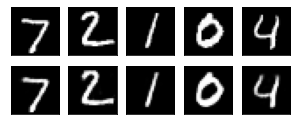

In [13]:
imgs = test[:5]
predicted = ae.predict(imgs)

plotDigits(imgs, predicted)

4. Создание моделей.

In [5]:
noiseencoder = createEncoder(noiser="y")
featureExtractor = keras.Model(
    inputs = noiseencoder.inputs,
    outputs = noiseencoder.get_layer(name="noiser").output
)

noisedecoder = createDecoder()
dae = createAE(encoder=noiseencoder, decoder=noisedecoder)
train2, test2 = mnist.load_data()

x_train2 = train2[0] / 255
x_test2 = test2[0] / 255

5. Обучение модели понижающего автокодировщика, подавляющего шум.

In [6]:
dae.fit(x_train2, x_train2, epochs = 3, batch_size = 32, validation_data = (x_test2, x_test2))

Epoch 1/3
1875/1875 [==============================] - 15s 7ms/step - loss: 0.1652 - val_loss: 0.1356
Epoch 2/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1313 - val_loss: 0.1250
Epoch 3/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1246 - val_loss: 0.1204


6. Визуализация результатов работы обученного подавляющего шум
автокодировщика на примерах изображений из тестового набора.

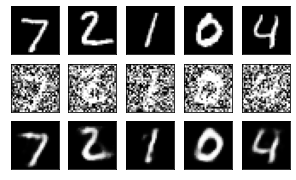

In [9]:
imgs = x_test2[:5]

predicted = dae.predict(imgs)
features = featureExtractor(predicted).numpy()

plotDigits(imgs, features, predicted)

7. Визуализация результатов работы обученного автокодировщика на примере изображений из текущей директории.

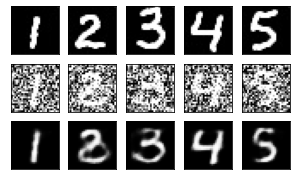

In [8]:
arrim = getArrayOfImgs()

predicted = dae.predict(arrim)
features = featureExtractor(predicted).numpy()

plotDigits(arrim, features, predicted)